In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import chi2
import wooldridge
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import linear_reset
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion as cv
from rpy2.robjects.conversion import localconverter
from tqdm import tqdm

In [2]:

# =========================
# 1) Load intdef and build spread
# =========================
df = wooldridge.data('intdef')
df.index = pd.to_datetime(df['year'], format='%Y')

# define series: 3-month T-bill (i3) minus inflation (inf)
y_full = (df['i3'] - df['inf']).astype(float)
y = y_full.dropna()   # series used for estimation

In [3]:
# =========================
# 2) Linear AR(1)
# =========================
ar1 = AutoReg(y, lags=1, old_names=False).fit()
rss_lin = float(np.sum(ar1.resid**2))
print("\n=== Linear AR(1) ===")
print(ar1.summary())


=== Linear AR(1) ===
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   56
Model:                     AutoReg(1)   Log Likelihood                -111.067
Method:               Conditional MLE   S.D. of innovations              1.823
Date:                qui, 21 ago 2025   AIC                            228.135
Time:                        15:53:55   BIC                            234.157
Sample:                    01-01-1949   HQIC                           230.464
                         - 01-01-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6968      0.270      2.582      0.010       0.168       1.226
y.L1           0.4450      0.105      4.257      0.000       0.240       0.650
                              

C:\Users\daves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [4]:
# =========================
# 3) TAR(1) via grid search (branch-free updates)
# =========================
y_lag_full = y.shift(1)
mask = y_lag_full.notna()
y_t = y[mask]
y_lag = y_lag_full[mask]

qmin, qmax, grid = 0.10, 0.90, 120
low = float(y_lag.quantile(qmin))
high = float(y_lag.quantile(qmax))
taus = np.linspace(low, high, grid)

best_tau = taus[0]
best_rss = 1e300
best_c_hi = 0.0; best_phi_hi = 0.0; best_c_lo = 0.0; best_phi_lo = 0.0

min_n = int(np.ceil(max(8, 0.10 * len(y_t))))  # minimum obs per regime

for tau in taus:
    mask_hi = y_lag > tau
    mask_lo = ~mask_hi

    X_hi = sm.add_constant(y_lag[mask_hi])
    X_lo = sm.add_constant(y_lag[mask_lo])

    res_hi = sm.OLS(y_t[mask_hi], X_hi).fit()
    res_lo = sm.OLS(y_t[mask_lo], X_lo).fit()

    yhat = pd.Series(index=y_t.index, dtype=float)
    yhat[mask_hi] = res_hi.predict(X_hi)
    yhat[mask_lo] = res_lo.predict(X_lo)

    rss = float(np.nansum((y_t - yhat)**2))

    # penalize thresholds with too few obs in a regime
    too_small = (mask_hi.sum() < min_n) or (mask_lo.sum() < min_n)
    rss = rss + 1e12 * float(too_small)

    # branch-free update (take min)
    better = rss < best_rss
    b = float(better)
    best_tau    = best_tau*(1-b)   + tau*b
    best_rss    = best_rss*(1-b)   + rss*b
    best_c_hi   = best_c_hi*(1-b)  + float(res_hi.params.iloc[0])*b
    best_phi_hi = best_phi_hi*(1-b)+ float(res_hi.params.iloc[1])*b
    best_c_lo   = best_c_lo*(1-b)  + float(res_lo.params.iloc[0])*b
    best_phi_lo = best_phi_lo*(1-b)+ float(res_lo.params.iloc[1])*b

print("\n=== TAR(1) ===")
print(f"tau* = {best_tau:.6f}")
print(f"RSS(TAR) = {best_rss:.2f}   RSS(AR1) = {rss_lin:.2f}")
print(f"HI regime: y_t = {best_c_hi:.4f} + {best_phi_hi:.4f} y_(t-1)")
print(f"LO regime: y_t = {best_c_lo:.4f} + {best_phi_lo:.4f} y_(t-1)")

s_hi = best_c_hi/(1-best_phi_hi)
s_lo = best_c_lo/(1-best_phi_lo)
print(f"Long-run HI: {s_hi:.4f}   Long-run LO: {s_lo:.4f}")


=== TAR(1) ===
tau* = 0.855596
RSS(TAR) = 126.83   RSS(AR1) = 182.78
HI regime: y_t = -0.1865 + 0.9345 y_(t-1)
LO regime: y_t = -0.4971 + -0.1792 y_(t-1)
Long-run HI: -2.8457   Long-run LO: -0.4216


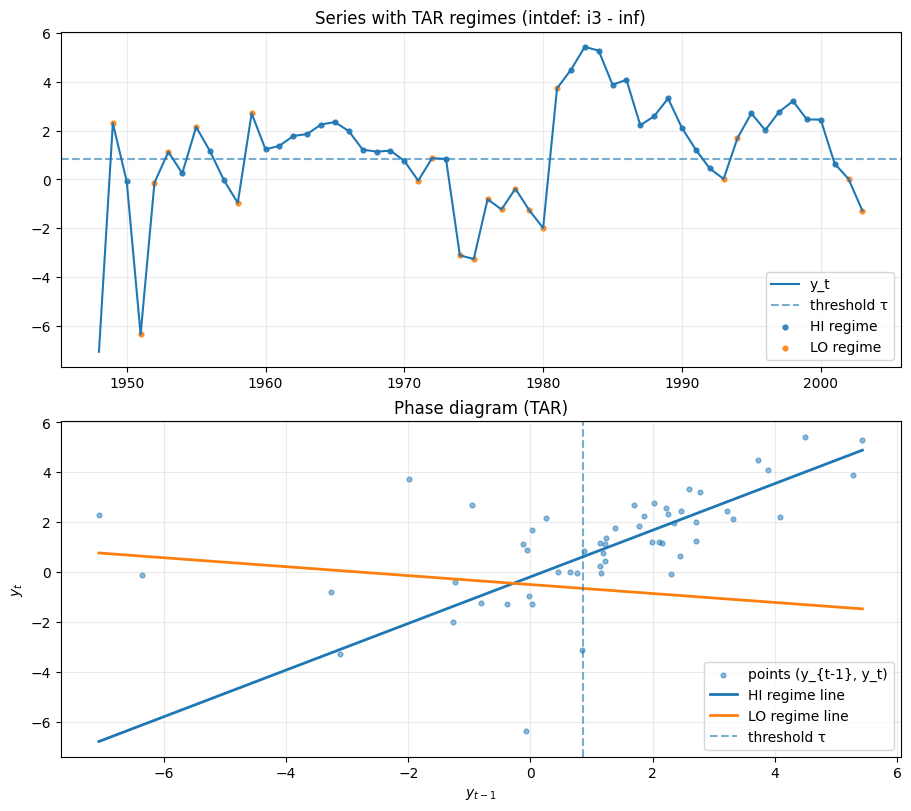


--- Diagnostics ---
RSS reduction TAR vs AR(1): 30.61%


In [5]:
# =========================
# 4) Plots
# =========================
fig, ax = plt.subplots(2, 1, figsize=(9, 8), constrained_layout=True)

# (a) time series with regimes
reg_hi = (y_lag > best_tau)
ax[0].plot(y_full.index, y_full.values, label='y_t')
ax[0].axhline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[0].scatter(y_t.index[reg_hi], y_t[reg_hi], s=12, alpha=0.85, label='HI regime')
ax[0].scatter(y_t.index[~reg_hi], y_t[~reg_hi], s=12, alpha=0.85, label='LO regime')
ax[0].set_title('Series with TAR regimes (intdef: i3 - inf)')
ax[0].legend()
ax[0].grid(alpha=0.25)

# (b) phase diagram
xgrid = np.linspace(float(y.min()), float(y.max()), 200)
line_hi = best_c_hi + best_phi_hi * xgrid
line_lo = best_c_lo + best_phi_lo * xgrid
ax[1].scatter(y_lag, y_t, s=12, alpha=0.5, label='points (y_{t-1}, y_t)')
ax[1].plot(xgrid, line_hi, lw=2, label='HI regime line')
ax[1].plot(xgrid, line_lo, lw=2, label='LO regime line')
ax[1].axvline(best_tau, ls='--', alpha=0.6, label='threshold τ')
ax[1].set_xlabel('$y_{t-1}$')
ax[1].set_ylabel('$y_t$')
ax[1].set_title('Phase diagram (TAR)')
ax[1].legend()
ax[1].grid(alpha=0.25)

plt.show()

print("\n--- Diagnostics ---")
print(f"RSS reduction TAR vs AR(1): {(1 - best_rss/rss_lin)*100:.2f}%")


=== Linear AR(1) ===
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   56
Model:                     AutoReg(1)   Log Likelihood                -111.067
Method:               Conditional MLE   S.D. of innovations              1.823
Date:                qui, 21 ago 2025   AIC                            228.135
Time:                        15:53:56   BIC                            234.157
Sample:                    01-01-1949   HQIC                           230.464
                         - 01-01-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6968      0.270      2.582      0.010       0.168       1.226
y.L1           0.4450      0.105      4.257      0.000       0.240       0.650
                              

C:\Users\daves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)



=== Bilinear BL(1,1,1,1) (grid + recursive residuals) ===
a0 = 0.4000, a1 = 0.5400, b1 = 0.1200, c1 = 0.0500
RSS(Bilinear) = 139.31


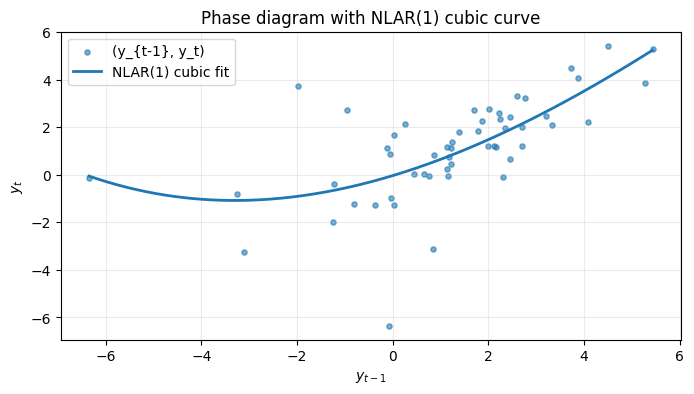

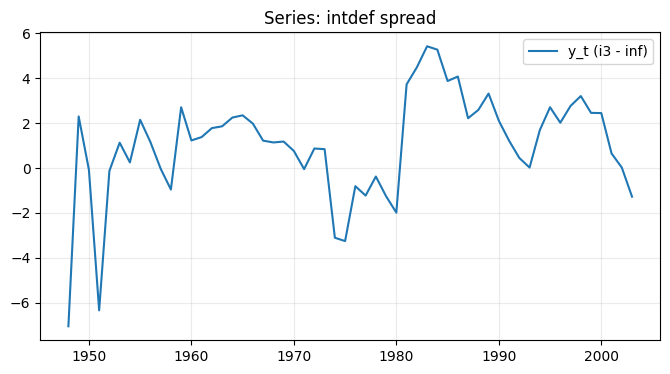


--- Model fit (RSS, lower is better) ---
AR(1):       182.78
NLAR(1):     130.68
GAR(2,deg3): 115.54
Bilinear:    139.31


In [6]:
### Simple extensions of the ARMA model

# Align lags
y_l1_full = y.shift(1)
y_l2_full = y.shift(2)
mask2 = y_l2_full.notna()
y_t = y[mask2]
y_l1 = y_l1_full[mask2]
y_l2 = y_l2_full[mask2]

# =========================================================
# LINEAR AR(1) (benchmark)
# =========================================================
ar1 = AutoReg(y, lags=1, old_names=False).fit()
rss_ar1 = float(np.sum(ar1.resid**2))

print("\n=== Linear AR(1) ===")
print(ar1.summary())

# =========================================================
# 1) SIMPLEST NLAR(1): cubic in y_{t-1}
#    y_t ~ 1, y_{t-1}, y_{t-1}^2, y_{t-1}^3
# =========================================================
X_nlar = pd.DataFrame({
    "const": 1.0,
    "y1": y_l1,
    "y1_sq": y_l1**2,
    "y1_cu": y_l1**3
}, index=y_t.index)

res_nlar = sm.OLS(y_t, X_nlar).fit()
rss_nlar = float(np.sum(res_nlar.resid**2))

print("\n=== Simplest NLAR(1) (cubic) ===")
print(res_nlar.summary())
print(f"RSS(NLAR) = {rss_nlar:.2f}   RSS(AR1) = {rss_ar1:.2f}")

# =========================================================
# 2) GAR(2) up to total degree 3 (with cross terms)
#    Columns: 1, y1, y2, y1^2, y2^2, y1*y2, y1^3, y2^3, y1^2*y2, y1*y2^2
# =========================================================
X_gar = pd.DataFrame({
    "const": 1.0,
    "y1": y_l1,
    "y2": y_l2,
    "y1_sq": y_l1**2,
    "y2_sq": y_l2**2,
    "y1y2": y_l1*y_l2,
    "y1_cu": y_l1**3,
    "y2_cu": y_l2**3,
    "y1sq_y2": (y_l1**2)*y_l2,
    "y1_y2sq": y_l1*(y_l2**2)
}, index=y_t.index)

res_gar = sm.OLS(y_t, X_gar).fit()
rss_gar = float(np.sum(res_gar.resid**2))

print("\n=== GAR(2) (degree ≤ 3 with cross-terms) ===")
print(res_gar.summary())
print(f"RSS(GAR) = {rss_gar:.2f}   RSS(NLAR) = {rss_nlar:.2f}   RSS(AR1) = {rss_ar1:.2f}")

# =========================================================
# 3) BILINEAR BL(1,1,1,1):
#    y_t = a0 + a1*y_{t-1} + b1*e_{t-1} + c1*(e_{t-1}*y_{t-1}) + e_t
#    Estimation by coarse grid search + recursive residuals (no functions)
# =========================================================
# Use the same aligned sample as GAR/NLAR (needs y_{t-1})
yt_bl = y_t.copy()
y1_bl = y_l1.copy()

# Grids (coarse, then one refinement around the best)
a0_grid = np.linspace(-1.0, 1.0, 11)   # α0
a1_grid = np.linspace(-0.8, 0.9, 18)   # α1
b1_grid = np.linspace(-0.8, 0.8, 9)    # β1
c1_grid = np.linspace(-1.0, 1.0, 9)    # γ1

best_rss_bl = 1e300
best_a0 = 0.0; best_a1 = 0.0; best_b1 = 0.0; best_c1 = 0.0

# Coarse search
for a0 in a0_grid:
    for a1 in a1_grid:
        for b1 in b1_grid:
            for c1 in c1_grid:
                e = np.zeros(len(yt_bl))
                t = 0
                # recursive residuals
                while t < len(yt_bl):
                    mu = a0 + a1*y1_bl.iloc[t] + b1*(e[t-1] if t>0 else 0.0) + c1*( (e[t-1] if t>0 else 0.0) * y1_bl.iloc[t] )
                    e[t] = yt_bl.iloc[t] - mu
                    t += 1
                rss = float(np.sum(e**2))
                better = rss < best_rss_bl
                b = float(better)
                best_rss_bl = best_rss_bl*(1-b) + rss*b
                best_a0 = best_a0*(1-b) + a0*b
                best_a1 = best_a1*(1-b) + a1*b
                best_b1 = best_b1*(1-b) + b1*b
                best_c1 = best_c1*(1-b) + c1*b

# One refinement around best (narrower grids)
a0_grid2 = np.linspace(best_a0-0.2, best_a0+0.2, 9)
a1_grid2 = np.linspace(best_a1-0.1, best_a1+0.1, 11)
b1_grid2 = np.linspace(best_b1-0.1, best_b1+0.1, 11)
c1_grid2 = np.linspace(best_c1-0.2, best_c1+0.2, 9)

for a0 in a0_grid2:
    for a1 in a1_grid2:
        for b1 in b1_grid2:
            for c1 in c1_grid2:
                e = np.zeros(len(yt_bl))
                t = 0
                while t < len(yt_bl):
                    mu = a0 + a1*y1_bl.iloc[t] + b1*(e[t-1] if t>0 else 0.0) + c1*( (e[t-1] if t>0 else 0.0) * y1_bl.iloc[t] )
                    e[t] = yt_bl.iloc[t] - mu
                    t += 1
                rss = float(np.sum(e**2))
                better = rss < best_rss_bl
                b = float(better)
                best_rss_bl = best_rss_bl*(1-b) + rss*b
                best_a0 = best_a0*(1-b) + a0*b
                best_a1 = best_a1*(1-b) + a1*b
                best_b1 = best_b1*(1-b) + b1*b
                best_c1 = best_c1*(1-b) + c1*b

print("\n=== Bilinear BL(1,1,1,1) (grid + recursive residuals) ===")
print(f"a0 = {best_a0:.4f}, a1 = {best_a1:.4f}, b1 = {best_b1:.4f}, c1 = {best_c1:.4f}")
print(f"RSS(Bilinear) = {best_rss_bl:.2f}")

# =========================================================
# PLOTS
# =========================================================
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.scatter(y_l1, y_t, s=14, alpha=0.6, label='(y_{t-1}, y_t)')
xg = np.linspace(float(y_l1.min()), float(y_l1.max()), 300)
yg_nlar = float(res_nlar.params.iloc[0]) + float(res_nlar.params.iloc[1])*xg + float(res_nlar.params.iloc[2])*(xg**2) + float(res_nlar.params.iloc[3])*(xg**3)
ax1.plot(xg, yg_nlar, lw=2, label='NLAR(1) cubic fit')
ax1.set_title('Phase diagram with NLAR(1) cubic curve')
ax1.set_xlabel('$y_{t-1}$'); ax1.set_ylabel('$y_t$'); ax1.legend(); ax1.grid(alpha=0.25)

fig2, ax2 = plt.subplots(figsize=(8,4))
ax2.plot(y_full.index, y_full.values, label='y_t (i3 - inf)')
ax2.set_title('Series: intdef spread')
ax2.legend(); ax2.grid(alpha=0.25)

plt.show()

print("\n--- Model fit (RSS, lower is better) ---")
print(f"AR(1):       {rss_ar1:.2f}")
print(f"NLAR(1):     {rss_nlar:.2f}")
print(f"GAR(2,deg3): {rss_gar:.2f}")
print(f"Bilinear:    {best_rss_bl:.2f}")


=== Diagnostic Plots for AR(1) Residuals ===


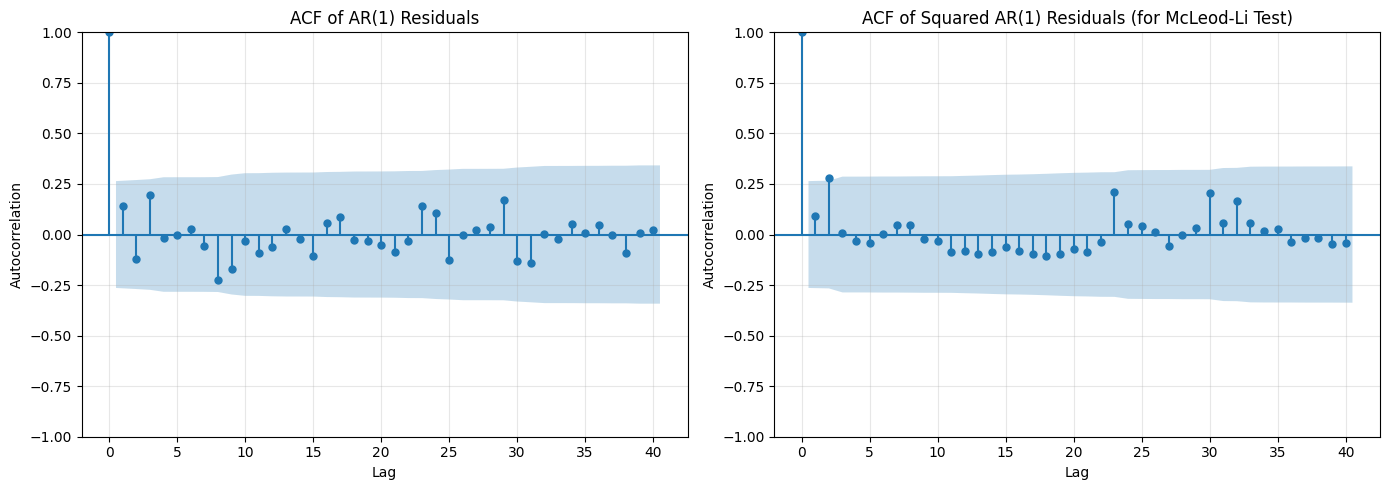


=== McLeod-Li Test Results (Ljung-Box on Squared Residuals) ===
      lb_stat  lb_pvalue
1    0.473014        NaN
2    5.142458   0.023348
3    5.146085   0.076303
4    5.200631   0.157682
5    5.307686   0.257158
6    5.308307   0.379424
7    5.444267   0.488218
8    5.584124   0.589057
9    5.614656   0.690307
10   5.688219   0.770671
11   6.210828   0.797250
12   6.695346   0.823191
13   7.381773   0.831388
14   7.963791   0.845951
15   8.279869   0.874242
16   8.810453   0.887218
17   9.559559   0.888596
18  10.488835   0.881871
19  11.291680   0.881572
20  11.754733   0.895840
21  12.465585   0.899120
22  12.589629   0.922317
23  16.871746   0.770400
24  17.126535   0.802996


In [7]:
## ACF and McLeod-Li test

# ===================================================================
# DIAGNOSTIC TESTS on AR(1) RESIDUALS
# We test the residuals of the linear model to see if nonlinearity is present.
# ===================================================================

# 1) Get the residuals from the benchmark AR(1) model
resid_ar1 = ar1.resid.dropna()

# ===================================================================
# 2) ACF PLOT OF RESIDUALS (Checks for Linear Structure)
# ===================================================================
print("\n=== Diagnostic Plots for AR(1) Residuals ===")
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF of the residuals themselves
plot_acf(resid_ar1, ax=ax[0], lags=40, title='ACF of AR(1) Residuals')
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(alpha=0.3)

# ===================================================================
# 3) MCLEOD-LI TEST (Checks for Nonlinear Structure / ARCH effects)
# This involves checking the ACF of the SQUARED residuals.
# ===================================================================

# Plot ACF of the SQUARED residuals
plot_acf(resid_ar1**2, ax=ax[1], lags=40, title='ACF of Squared AR(1) Residuals (for McLeod-Li Test)')
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Perform the formal McLeod-Li test using the Ljung-Box test on squared residuals
print("\n=== McLeod-Li Test Results (Ljung-Box on Squared Residuals) ===")
# The degrees of freedom for the test must be adjusted by the number of
# parameters in the original model (p+q). For AR(1), p=1, q=0, so model_df=1.
ml_test_results = acorr_ljungbox(resid_ar1**2, lags=range(1, 25), model_df=1, return_df=True)

print(ml_test_results)

In [8]:
# ===================================================================
# Ramsey RESET Test for Nonlinearity (Manual Implementation)
# ===================================================================

# --- 1. Set up the rpy2 Environment ---
# Ensure the necessary R packages are available.
try:
    lmtest = importr('lmtest')
    dplyr = importr('dplyr') # For the convenient lag() function
except ro.packages.PackageNotInstalledError as e:
    print(f"Error: A required R package is not installed.")
    print(f"Please open R and run: install.packages('{e.name}')")
    # In a real script, you might exit() here.

# --- 2. Prepare Data in Python ---
# We use the 'y' Series (the dependent variable) from the previous model fitting.
# We will send this entire series to R to replicate the model fit.
print("Preparing to send the time series 'y' to R.")
print("-" * 50)


# --- 3. Run the Test in R via Python ---
try:
    # Use the 'localconverter' for robust data type conversion.
    with cv.localconverter(ro.default_converter + pandas2ri.converter):
      # Assign the pandas Series to a variable in R's global environment.
      ro.r.assign("y_py", y)

    # Define the R code block as a multi-line string.
    r_script = """
    # Load required R libraries
    suppressPackageStartupMessages(library(lmtest))
    suppressPackageStartupMessages(library(dplyr))

    # Fit the AR(1) model in R, which is the equivalent of the Python AutoReg.
    # 'na.action = na.omit' is crucial to handle the missing value from lag().
    ar1_model_r <- lm(y_py ~ lag(y_py), na.action = na.omit)

    # Perform the Ramsey RESET test on the fitted R model object.
    # power = 2:3 includes the squared and cubed fitted values.
    reset_results <- resettest(ar1_model_r, power = 2:3, type = "fitted")

    # Print the test results so they can be captured by Python.
    print(reset_results)
    """

    # Execute the R code string and store the result.
    # rpy2 captures the printed output from R.
    test_results = ro.r(r_script)

    print("\n=== Ramsey RESET Test Results (from R's lmtest) ===")
    print(test_results)

except Exception as e:
    print(f"An error occurred during the R execution: {e}")

Preparing to send the time series 'y' to R.
--------------------------------------------------

	RESET test

data:  ar1_model_r
RESET = 9.8491, df1 = 2, df2 = 51, p-value = 0.0002416


=== Ramsey RESET Test Results (from R's lmtest) ===
None


In [13]:
# ===================================================================
# Lagrange Multiplier (LM) Test for Nonlinearity
# (Testing AR(1) vs. Cubic NLAR(1)) — robust, no reliance on model.exog
# ===================================================================
from scipy.stats import chi2
import statsmodels.api as sm
import numpy as np
import pandas as pd

# 1) Recreate the aligned sample for AR(1)
y1_full = y.shift(1)
mask = y1_full.notna()
y_t   = y[mask]
y1    = y1_full[mask]

# Residuals from your fitted AR(1); align to the same index as y_t
residuals = pd.Series(ar1.resid, index=y_t.index)

# Detect if AR(1) had a constant by checking parameter names
has_const = any(str(n).lower().startswith("const") for n in ar1.params.index)

# 2) Build ORIGINAL regressors (what was in the AR(1)) and add nonlinear terms
X_orig = pd.DataFrame({"y1": y1}, index=y_t.index)
if has_const:
    X_orig.insert(0, "const", 1.0)

X_aux = X_orig.copy()
X_aux["y1_sq"] = y1**2
X_aux["y1_cu"] = y1**3

# 3) Auxiliary regression: e_t on [original regressors + new terms]
aux_model = sm.OLS(residuals, X_aux).fit()

# 4) LM statistic: T * R^2, df = number of NEW regressors (2: y1^2, y1^3)
T = int(aux_model.nobs)
R2 = float(aux_model.rsquared)
LM = T * R2
df = 2
pval = chi2.sf(LM, df)

print("\n=== LM Test for Cubic Nonlinearity (AR(1) vs. NLAR) ===")
print(f"T = {T}")
print(f"R^2 (aux) = {R2:.4f}")
print(f"LM = {LM:.4f}, df = {df}, p-value = {pval:.4f}")

alpha = 0.05
if pval < alpha:
    print("⇒ Reject H0: evidence that cubic NLAR(1) improves over linear AR(1).")
else:
    print("⇒ Fail to reject H0: no strong evidence favoring cubic NLAR(1).")



=== LM Test for Cubic Nonlinearity (AR(1) vs. NLAR) ===
T = 55
R^2 (aux) = 0.2786
LM = 15.3243, df = 2, p-value = 0.0005
⇒ Reject H0: evidence that cubic NLAR(1) improves over linear AR(1).


In [15]:
# ===================================================================
# THRESHOLD AUTOREGRESSIVE (TAR) MODEL
# ===================================================================

# --- CORRECTED DATA PREPARATION ---
# 1. Create a single DataFrame with the dependent variable and its lags.
#    This is a more robust way to handle missing data from lagging.
tar_df = pd.DataFrame({
    'y_t': y,
    'y_l1': y.shift(1),
    'y_l2': y.shift(2)
})

# 2. Drop all rows with any NaN values to get a perfectly aligned dataset.
tar_df.dropna(inplace=True)

# 3. Define the threshold and create the indicator variable from the cleaned data.
threshold = 0.0
indicator = (tar_df['y_l1'] > threshold).astype(int)

# 4. Construct the regressors for each regime using the clean, aligned data.
X_tar = pd.DataFrame({
    # Regressors for Regime 1 (y_{t-1} > 0)
    "const_pos": indicator,
    "y1_pos": tar_df['y_l1'] * indicator,
    "y2_pos": tar_df['y_l2'] * indicator,
    
    # Regressors for Regime 2 (y_{t-1} <= 0)
    "const_neg": 1 - indicator,
    "y1_neg": tar_df['y_l1'] * (1 - indicator),
    "y2_neg": tar_df['y_l2'] * (1 - indicator)
})

# 5. Estimate the single regression using OLS.
# The dependent variable y_t must also come from the cleaned DataFrame.
res_tar = sm.OLS(tar_df['y_t'], X_tar).fit()
rss_tar = float(np.sum(res_tar.resid**2))

print("\n=== Threshold AR(2) Model (TAR) | Threshold: y_{t-1} > 0 ===")
print(res_tar.summary())
print(f"RSS(TAR) = {rss_tar:.2f}")

# You can also compare this RSS to the other models
print("\n--- Model fit (RSS, lower is better) ---")
print(f"AR(1):       {rss_ar1:.2f}")
print(f"NLAR(1):     {rss_nlar:.2f}")
print(f"GAR(2,deg3): {rss_gar:.2f}")
print(f"Bilinear:    {best_rss_bl:.2f}")
print(f"TAR(2):      {rss_tar:.2f}")


=== Threshold AR(2) Model (TAR) | Threshold: y_{t-1} > 0 ===
                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     11.20
Date:                qui, 21 ago 2025   Prob (F-statistic):           3.48e-07
Time:                        16:08:14   Log-Likelihood:                -96.217
No. Observations:                  54   AIC:                             204.4
Df Residuals:                      48   BIC:                             216.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [16]:
# ===================================================================
# Three-Regime Band-TAR with Optimal Delay Parameter Selection
# ===================================================================

# Search for the best delay parameter 'd' from 1 to 5 lags
best_delay = -1
min_rss = float('inf')
best_model_results = None
best_thresholds = {}

print("Searching for the best delay parameter (d)...")
for d in range(1, 6):
    # 1. Prepare data for the current delay 'd'
    # The threshold variable is y_{t-d}
    y_delay = y.shift(d)
    
    # Align all series (y_t, y_{t-1}, and y_{t-d}) to have the same length
    aligned_data = pd.concat([y, y.shift(1), y_delay], axis=1).dropna()
    aligned_data.columns = ['y_t', 'y_l1', 'y_delay']
    
    y_t_d = aligned_data['y_t']
    y_l1_d = aligned_data['y_l1']
    y_delay_d = aligned_data['y_delay']

    # 2. Define the upper and lower thresholds based on data quantiles
    tau_lower = y_delay_d.quantile(0.30)
    tau_upper = y_delay_d.quantile(0.70)

    # 3. Create three indicator variables
    indicator_upper = (y_delay_d > tau_upper).astype(int)
    indicator_lower = (y_delay_d < tau_lower).astype(int)
    indicator_middle = ((y_delay_d >= tau_lower) & (y_delay_d <= tau_upper)).astype(int)

    # 4. Construct regressors for the three regimes (using TAR(1) for simplicity)
    X_band_tar = pd.DataFrame({
        # Upper Regime
        "const_upper": indicator_upper,
        "y1_upper": y_l1_d * indicator_upper,
        # Middle (Band) Regime
        "const_middle": indicator_middle,
        "y1_middle": y_l1_d * indicator_middle,
        # Lower Regime
        "const_lower": indicator_lower,
        "y1_lower": y_l1_d * indicator_lower,
    }, index=y_t_d.index)

    # 5. Estimate the model and calculate RSS
    res_band_tar = sm.OLS(y_t_d, X_band_tar).fit()
    current_rss = np.sum(res_band_tar.resid**2)
    
    print(f"  - Delay d={d}: RSS = {current_rss:.2f}")

    # 6. Check if this is the best model so far
    if current_rss < min_rss:
        min_rss = current_rss
        best_delay = d
        best_model_results = res_band_tar
        best_thresholds = {'lower': tau_lower, 'upper': tau_upper}

# ===================================================================
# Results for the Best Model
# ===================================================================
print("\n--- Best Model Found ---")
print(f"Optimal Delay Parameter (d): {best_delay}")
print(f"Lowest RSS: {min_rss:.2f}")
print(f"Thresholds used: Lower={best_thresholds['lower']:.3f}, Upper={best_thresholds['upper']:.3f}")

print("\n=== Summary for Best Three-Regime Band-TAR Model ===")
print(best_model_results.summary())

Searching for the best delay parameter (d)...
  - Delay d=1: RSS = 129.92
  - Delay d=2: RSS = 109.93
  - Delay d=3: RSS = 141.10
  - Delay d=4: RSS = 97.53
  - Delay d=5: RSS = 82.16

--- Best Model Found ---
Optimal Delay Parameter (d): 5
Lowest RSS: 82.16
Thresholds used: Lower=0.250, Upper=2.220

=== Summary for Best Three-Regime Band-TAR Model ===
                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     10.75
Date:                qui, 21 ago 2025   Prob (F-statistic):           7.67e-07
Time:                        16:11:57   Log-Likelihood:                -84.525
No. Observations:                  51   AIC:                             181.1
Df Residuals:                      45   BIC:                             192.6
Df Model:    

Searching over 38 potential threshold values...
Search complete.

--- Optimal Threshold Found ---
Estimated Threshold (τ): 0.4500
Minimum Sum of Squared Residuals (SSR): 114.8092


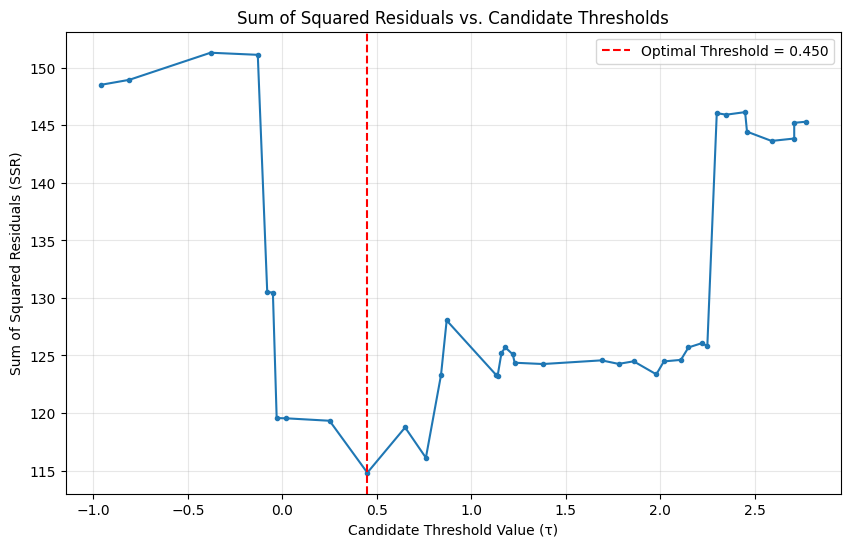

In [17]:
# ===================================================================
# Optimal Threshold Estimation for the TAR Model
# ===================================================================

# 1. Prepare the data
# We use d=2, so the threshold variable is y_{t-2}
delay = 2
y_thresh_var = y.shift(delay)
y_l1 = y.shift(1)

aligned_data = pd.concat([y, y_l1, y_thresh_var], axis=1).dropna()
aligned_data.columns = ['y_t', 'y_l1', 'y_thresh']
y_t_search = aligned_data['y_t']
y_l1_search = aligned_data['y_l1']
y_thresh_search = aligned_data['y_thresh']

# 2. Define the set of candidate thresholds
# Sort the unique values of the threshold variable
sorted_thresholds = np.unique(y_thresh_search)

# Trim the top and bottom 15% as suggested by the textbook
n = len(sorted_thresholds)
trim_lower = int(n * 0.15)
trim_upper = int(n * 0.85)
candidate_thresholds = sorted_thresholds[trim_lower:trim_upper]

# 3. Perform the grid search
results = []
print(f"Searching over {len(candidate_thresholds)} potential threshold values...")

for tau in candidate_thresholds:
    # Create indicator variable for the current threshold 'tau'
    indicator = (y_thresh_search > tau).astype(int)
    
    # Construct regressors for a simple TAR(1) model in each regime
    X_search = pd.DataFrame({
        "const_upper": indicator,
        "y1_upper": y_l1_search * indicator,
        "const_lower": 1 - indicator,
        "y1_lower": y_l1_search * (1 - indicator)
    }, index=y_t_search.index)
    
    # Fit the model and store the SSR (Sum of Squared Residuals)
    res = sm.OLS(y_t_search, X_search).fit()
    results.append({'threshold': tau, 'ssr': res.ssr})

print("Search complete.")

# 4. Find the optimal threshold that minimizes the SSR
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['ssr'].idxmin()]
optimal_threshold = best_result['threshold']
min_ssr = best_result['ssr']

print("\n--- Optimal Threshold Found ---")
print(f"Estimated Threshold (τ): {optimal_threshold:.4f}")
print(f"Minimum Sum of Squared Residuals (SSR): {min_ssr:.4f}")

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['ssr'], marker='.', linestyle='-')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.title('Sum of Squared Residuals vs. Candidate Thresholds')
plt.xlabel('Candidate Threshold Value (τ)')
plt.ylabel('Sum of Squared Residuals (SSR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [23]:
# ===================================================================
# Helper Function: Run Threshold Search
# This function encapsulates the grid search from the previous step.
# ===================================================================
def run_threshold_search(series, delay, lags=1):
    """
    Performs a grid search for the optimal threshold in a TAR model.
    Returns the minimum Sum of Squared Residuals (SSR).
    """
    y_t = series
    y_thresh_var = series.shift(delay)
    y_lags = {f'y_l{i}': series.shift(i) for i in range(1, lags + 1)}

    aligned_data = pd.concat([y_t, y_thresh_var] + list(y_lags.values()), axis=1).dropna()
    aligned_data.columns = ['y_t', 'y_thresh'] + list(y_lags.keys())
    
    y_t_s = aligned_data['y_t']
    y_thresh_s = aligned_data['y_thresh']
    y_lags_s = {key: aligned_data[key] for key in y_lags.keys()}

    sorted_thresholds = np.unique(y_thresh_s)
    n = len(sorted_thresholds)
    trim_lower, trim_upper = int(n * 0.15), int(n * 0.85)
    candidate_thresholds = sorted_thresholds[trim_lower:trim_upper]
    
    if len(candidate_thresholds) == 0: # Handle cases with too few unique values
        return float('inf')

    min_ssr_for_series = float('inf')
    for tau in candidate_thresholds:
        indicator = (y_thresh_s > tau).astype(int)
        X_search = pd.DataFrame({"const_upper": indicator, "const_lower": 1 - indicator})
        for i in range(1, lags + 1):
            lag_name = f'y_l{i}'
            X_search[f'{lag_name}_upper'] = y_lags_s[lag_name] * indicator
            X_search[f'{lag_name}_lower'] = y_lags_s[lag_name] * (1 - indicator)
        
        res = sm.OLS(y_t_s, X_search).fit()
        if res.ssr < min_ssr_for_series:
            min_ssr_for_series = res.ssr
            
    return min_ssr_for_series

# ===================================================================
# Main Script: Hansen Bootstrap Test for Thresholding
# ===================================================================
# --- Step 1: Fit models to the ORIGINAL data ---
print("Fitting models to original data...")
# Restricted Model (Linear AR(2))
ar_order = 2
linear_model = sm.OLS(y.iloc[ar_order:], sm.add_constant(pd.concat([y.shift(i) for i in range(1, ar_order + 1)], axis=1).iloc[ar_order:])).fit()
ssr_restricted = linear_model.ssr

# Unrestricted Model (Best TAR model) - using the function on our data
# We use d=2 from our previous finding
optimal_delay = 2
ssr_unrestricted = run_threshold_search(y, delay=optimal_delay, lags=ar_order)

# Calculate the F-statistic on the original data
T = linear_model.nobs
n_params_linear = ar_order + 1 # p lags + 1 constant
original_f_stat = ((ssr_restricted - ssr_unrestricted) / n_params_linear) / (ssr_unrestricted / (T - 2 * n_params_linear))

# --- Step 2: Run the Bootstrap Simulation ---
n_bootstrap = 500 # Use at least 500; 1000 is better but slower
bootstrap_f_stats = []
linear_residuals = linear_model.resid
linear_params = linear_model.params

print(f"\nRunning bootstrap with {n_bootstrap} repetitions...")
for _ in tqdm(range(n_bootstrap)):
    # Create bootstrap residuals and generate a new y* series under the null
    boot_resid = np.random.choice(linear_residuals, size=len(y), replace=True)
    y_star = np.zeros(len(y))
    for t in range(ar_order, len(y)):
        y_star[t] = linear_params[0] + np.dot(linear_params[1:], y_star[t-ar_order:t][::-1]) + boot_resid[t]
    
    y_star_series = pd.Series(y_star, index=y.index)
    
    # Fit restricted (linear) model to y*
    ar_star = sm.OLS(y_star_series.iloc[ar_order:], sm.add_constant(pd.concat([y_star_series.shift(i) for i in range(1, ar_order + 1)], axis=1).iloc[ar_order:])).fit()
    ssr_r_star = ar_star.ssr
    
    # Fit unrestricted (TAR) model to y*
    ssr_u_star = run_threshold_search(y_star_series, delay=optimal_delay, lags=ar_order)
    
    # Calculate and store the bootstrap F-statistic
    if ssr_u_star != float('inf'):
        f_star = ((ssr_r_star - ssr_u_star) / n_params_linear) / (ssr_u_star / (ar_star.nobs - 2 * n_params_linear))
        bootstrap_f_stats.append(f_star)

# --- Step 3: Calculate p-value and critical value ---
p_value = np.mean(np.array(bootstrap_f_stats) > original_f_stat)
crit_val_95 = np.percentile(bootstrap_f_stats, 95)

# --- Step 4: Display Results ---
print("\n--- Hansen's Bootstrap Test for Threshold Effect ---")
print(f"Null Hypothesis (H0): The model is linear (no threshold effect).")
print("-------------------------------------------------------")
print(f"F-statistic from original data: {original_f_stat:.4f}")
print(f"Bootstrapped 95% critical value: {crit_val_95:.4f}")
print(f"Bootstrapped p-value: {p_value:.4f}")
print("-------------------------------------------------------")

if p_value < 0.05:
    print("✅ Interpretation: Reject H0. There is a significant threshold effect.")
else:
    print("✅ Interpretation: Fail to reject H0. There is no significant evidence of a threshold effect.")

Fitting models to original data...

Running bootstrap with 500 repetitions...


100%|██████████| 500/500 [00:27<00:00, 18.19it/s]


--- Hansen's Bootstrap Test for Threshold Effect ---
Null Hypothesis (H0): The model is linear (no threshold effect).
-------------------------------------------------------
F-statistic from original data: 5.9873
Bootstrapped 95% critical value: 5.4053
Bootstrapped p-value: 0.0360
-------------------------------------------------------
✅ Interpretation: Reject H0. There is a significant threshold effect.


In [28]:
# ===================================================================
# Helper Function: Search for Optimal Break Date
# This function loops through time to find the break date that minimizes SSR.
# ===================================================================

# 1. Ensure the 'strucchange' package is installed in R
utils = importr("utils")
try:
    strucchange = importr("strucchange")
except PackageNotInstalledError:
    print("Installing R package 'strucchange'...")
    #utils.install_packages("strucchange", repos="https://cloud.r-project.org")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")

# 2. Prepare the data in a pandas DataFrame
# The R function needs a dataframe with the dependent and independent variables.
ar_order = 1
# Create a dataframe with y and its lag, dropping missing values
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['y', 'y_lag1']

# 3. Execute the R code via rpy2
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

ro.globalenv['df_from_py'] = r_df

r_code = """
# Load the library
suppressPackageStartupMessages(library(strucchange))

# Define the model formula (y_t ~ y_{t-1})
formula <- y ~ y_lag1

# Perform the Sup-F test for a single unknown breakpoint.
# 'from = 0.15' trims the first 15% of the sample, as recommended.
test_result <- sctest(formula, data = df_from_py, type = "supF", from = 0.15)

# Extract and return the F-statistic and the p-value
out <- list(
    statistic = as.numeric(test_result$statistic),
    p_value = as.numeric(test_result$p.value)
)
out
"""

# Run the R code
r_results = ro.r(r_code)

# Extract results from the R list object
sup_f_stat_r = r_results.rx2('statistic')[0]
p_value_r = r_results.rx2('p_value')[0]


# --- Display the final results ---
print("\n--- Endogenous Break Test via R's 'strucchange' ---")
print(f"Null Hypothesis (H0): No structural break (stable linear model).")
print("----------------------------------------------------------")
print(f"Supremum F-statistic: {sup_f_stat_r:.4f}")
print(f"p-value: {p_value_r:.4f}")
print("----------------------------------------------------------")

if p_value_r < 0.05:
    print("✅ Interpretation: Reject H0. There is a significant structural break.")
else:
    print("✅ Interpretation: Fail to reject H0. No significant evidence of a structural break.")


--- Endogenous Break Test via R's 'strucchange' ---
Null Hypothesis (H0): No structural break (stable linear model).
----------------------------------------------------------
Supremum F-statistic: 19.2137
p-value: 0.0017
----------------------------------------------------------
✅ Interpretation: Reject H0. There is a significant structural break.


In [29]:
# ===================================================================
# R NATIVE FUNCTION TO FIND THE BREAK DATE
# ===================================================================

# 1. Ensure the 'strucchange' package is installed in R
utils = importr("utils")
try:
    strucchange = importr("strucchange")
except PackageNotInstalledError:
    print("Installing R package 'strucchange'...")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")

# 2. Prepare the data (same as before)
ar_order = 1
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['y', 'y_lag1']

# 3. Execute the R code via rpy2
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

ro.globalenv['df_from_py'] = r_df

r_code = """
# Load the library
suppressPackageStartupMessages(library(strucchange))

# Define the model formula (y_t ~ y_{t-1})
formula <- y ~ y_lag1

# Estimate the single most likely breakpoint
# h = 0.15 ensures each regime has at least 15% of the observations
bp <- breakpoints(formula, data = df_from_py, h = 0.15)

# Get the observation number of the break
# NOTE: R returns the observation number (e.g., the 100th row), not the date itself
break_obs_number <- bp$breakpoints

# Also get the 95% confidence interval for the break
ci <- confint(bp, breaks = 1)

# Return the results as a list
out <- list(
    break_obs = as.numeric(break_obs_number),
    ci_lower_obs = as.numeric(ci$confint[1]),
    ci_upper_obs = as.numeric(ci$confint[2])
)
out
"""

# Run the R code
r_results = ro.r(r_code)

# 4. Extract results and map observation numbers back to dates
# R uses 1-based indexing, so we subtract 1 for Python's 0-based indexing
break_obs_py = int(r_results.rx2('break_obs')[0]) - 1
ci_lower_py = int(r_results.rx2('ci_lower_obs')[0]) - 1
ci_upper_py = int(r_results.rx2('ci_upper_obs')[0]) - 1

# Get the actual dates from our prepared dataframe's index
estimated_date = df_for_r.index[break_obs_py]
ci_lower_date = df_for_r.index[ci_lower_py]
ci_upper_date = df_for_r.index[ci_upper_py]


# --- Display the final results ---
print("\n--- Estimated Structural Break Point ---")
print(f"Most Likely Break Date: {estimated_date.strftime('%Y-%m-%d')}")
print(f"95% Confidence Interval: [{ci_lower_date.strftime('%Y-%m-%d')}, {ci_upper_date.strftime('%Y-%m-%d')}]")


--- Estimated Structural Break Point ---
Most Likely Break Date: 1959-01-01
95% Confidence Interval: [1956-01-01, 1959-01-01]


Running multiple structural breaks analysis...


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In is.na(bp_fit$RSS) :  
R callback write-console: 
   
R callback write-console:  is.na() applied to non-(list or vector) of type 'closure'
  
R callback write-console: 2:   
R callback write-console: In is.na(bp_fit$RSS) :  
R callback write-console: 
   
R callback write-console:  is.na() applied to non-(list or vector) of type 'closure'
  
R callback write-console: 3:   
R callback write-console: In is.na(bp_fit$RSS) :  
R callback write-console: 
   
R callback write-console:  is.na() applied to non-(list or vector) of type 'closure'
  
R callback write-console: 4:   
R callback write-console: In is.na(bp_fit$RSS) :  
R callback write-console: 
   
R callback write-console:  is.na() applied to non-(list or vector) of type 'closure'
  
R callback write-console: 5:   
R callback write-console: In is.na(bp_fit$RSS) :  
R callback write-con


--- Debugging R Results ---
R results structure:
[1]
[4]
[7]

Max breaks tested: 5
Valid breaks: [0 1 2 3 4 5]
RSS values shape: (6,)
RSS values: [182.778026   0.         0.         0.         0.         0.      ]

MULTIPLE STRUCTURAL BREAKS ANALYSIS RESULTS

Optimal number of breaks (RSS criterion): 1
Optimal number of breaks (BIC criterion): 1

Estimated Break Dates (BIC optimal):
  - Break 1: 1959-01-01

Breaks   RSS          AIC          BIC         
------------------------------------------------
0        182.78       228.13       234.16      
1        0.00         0.00         0.00        
2        0.00         0.00         0.00        
3        0.00         0.00         0.00        
4        0.00         0.00         0.00        
5        0.00         0.00         0.00        


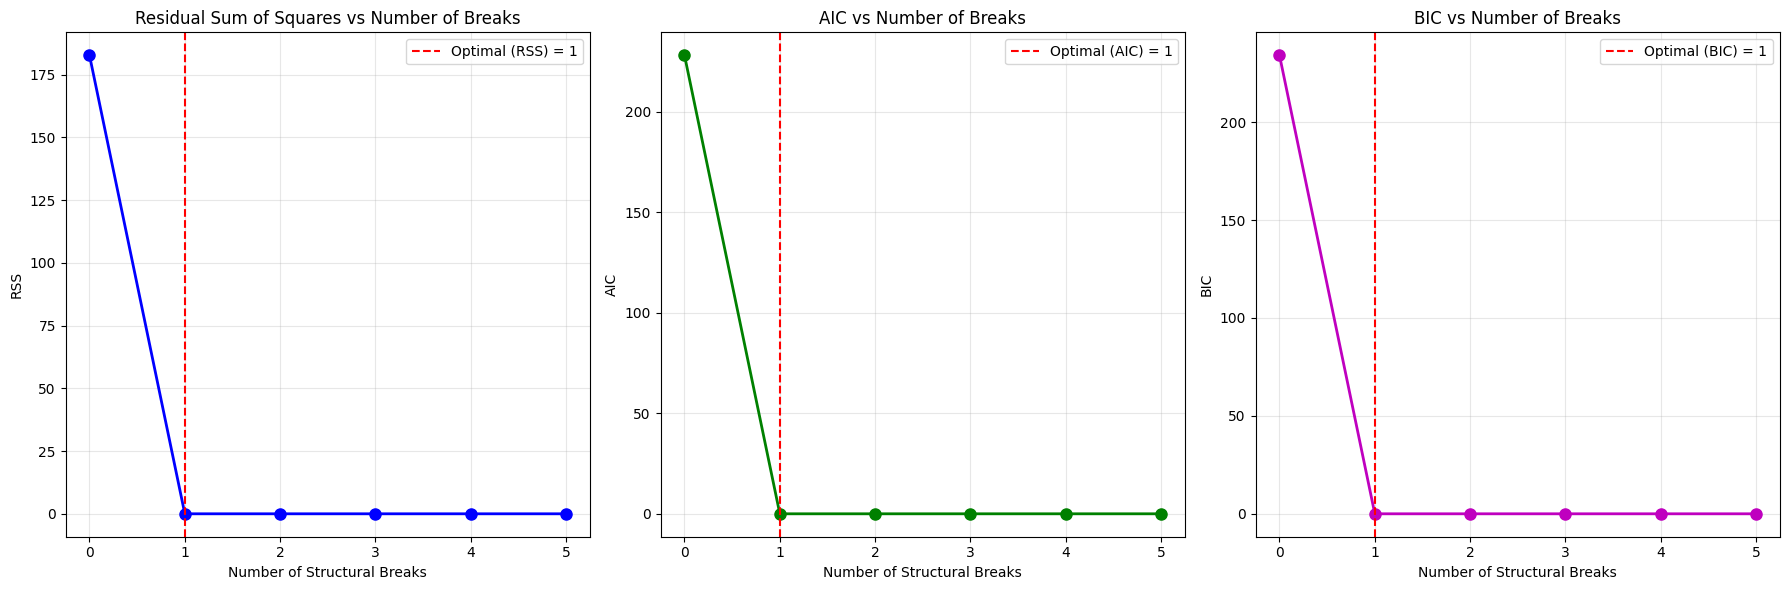


ANALYSIS COMPLETE


In [32]:
# ===================================================================
# R NATIVE FUNCTION TO FIND MULTIPLE BREAK DATES
# ===================================================================

# 1. Ensure the 'strucchange' package is installed in R
utils = importr("utils")
try:
    strucchange = importr("strucchange")
except PackageNotInstalledError:
    print("Installing R package 'strucchange'...")
    utils.install_packages("strucchange")
    strucchange = importr("strucchange")

# 2. Prepare the data (same as before)
ar_order = 1
df_for_r = pd.concat([y, y.shift(ar_order)], axis=1).dropna()
df_for_r.columns = ['y', 'y_lag1']

# 3. Execute the R code via rpy2
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df_for_r)

ro.globalenv['df_from_py'] = r_df

# IMPROVED R CODE - Better handling of RSS extraction
r_code = """
suppressPackageStartupMessages(library(strucchange))
formula <- y ~ y_lag1

# Try different numbers of breaks (0 to 5)
max_breaks <- min(5, floor(nrow(df_from_py) * 0.15))  # Respect the 15% rule
rss_values <- numeric(max_breaks + 1)
aic_values <- numeric(max_breaks + 1)
bic_values <- numeric(max_breaks + 1)

# Fit models with 0 to max_breaks
for(i in 0:max_breaks) {
    if(i == 0) {
        # Linear model (no breaks)
        lm_fit <- lm(formula, data = df_from_py)
        rss_values[i + 1] <- sum(residuals(lm_fit)^2)
        aic_values[i + 1] <- AIC(lm_fit)
        bic_values[i + 1] <- BIC(lm_fit)
    } else {
        # Model with i breaks
        tryCatch({
            bp_fit <- breakpoints(formula, data = df_from_py, breaks = i, h = 0.15)
            if(!is.na(bp_fit$RSS)) {
                rss_values[i + 1] <- bp_fit$RSS
                # Calculate AIC/BIC for break model
                fitted_model <- lm(formula, data = df_from_py, subset = bp_fit$breakpoints)
                n <- nrow(df_from_py)
                k <- 2 * (i + 1)  # parameters: intercepts + slopes for each regime
                rss <- bp_fit$RSS
                aic_values[i + 1] <- n * log(rss/n) + 2 * k
                bic_values[i + 1] <- n * log(rss/n) + log(n) * k
            } else {
                rss_values[i + 1] <- NA
                aic_values[i + 1] <- NA
                bic_values[i + 1] <- NA
            }
        }, error = function(e) {
            rss_values[i + 1] <- NA
            aic_values[i + 1] <- NA
            bic_values[i + 1] <- NA
        })
    }
}

# Find optimal number of breaks
valid_rss <- !is.na(rss_values)
if(any(valid_rss)) {
    optimal_breaks_rss <- which.min(rss_values[valid_rss]) - 1
    optimal_breaks_bic <- which.min(bic_values[valid_rss]) - 1
    
    # Get breakpoints for optimal model
    if(optimal_breaks_bic > 0) {
        bp_optimal <- breakpoints(formula, data = df_from_py, breaks = optimal_breaks_bic, h = 0.15)
        break_obs_numbers <- bp_optimal$breakpoints
    } else {
        break_obs_numbers <- integer(0)
    }
} else {
    optimal_breaks_rss <- 0
    optimal_breaks_bic <- 0
    break_obs_numbers <- integer(0)
}

# Return results
out <- list(
    max_breaks_tested = max_breaks,
    rss_values = rss_values[valid_rss],
    aic_values = aic_values[valid_rss],
    bic_values = bic_values[valid_rss],
    valid_breaks = (0:max_breaks)[valid_rss],
    optimal_breaks_rss = optimal_breaks_rss,
    optimal_breaks_bic = optimal_breaks_bic,
    break_obs = break_obs_numbers
)
out
"""

# Run the improved R code
print("Running multiple structural breaks analysis...")
r_results = ro.r(r_code)

# 4. FIXED EXTRACTION AND PROCESSING
print("\n--- Debugging R Results ---")
print("R results structure:")
print(r_results.names)

# Extract data more carefully
try:
    max_breaks_tested = int(r_results.rx2('max_breaks_tested')[0])
    rss_values = np.array(r_results.rx2('rss_values'))
    aic_values = np.array(r_results.rx2('aic_values'))
    bic_values = np.array(r_results.rx2('bic_values'))
    valid_breaks = np.array(r_results.rx2('valid_breaks')).astype(int)
    optimal_breaks_rss = int(r_results.rx2('optimal_breaks_rss')[0])
    optimal_breaks_bic = int(r_results.rx2('optimal_breaks_bic')[0])
    
    print(f"Max breaks tested: {max_breaks_tested}")
    print(f"Valid breaks: {valid_breaks}")
    print(f"RSS values shape: {rss_values.shape}")
    print(f"RSS values: {rss_values}")
    
    # Extract break dates if any
    break_dates = []
    if optimal_breaks_bic > 0:
        break_obs_r = r_results.rx2('break_obs')
        if len(break_obs_r) > 0:
            break_obs_py = np.array(break_obs_r).astype(int) - 1  # Convert to 0-based indexing
            break_dates = [df_for_r.index[obs] for obs in break_obs_py if obs < len(df_for_r)]

except Exception as e:
    print(f"Error extracting results: {e}")
    print("Raw R results:")
    print(r_results)
    # Fallback values
    max_breaks_tested = 5
    rss_values = np.array([182.78])  # Just the AR(1) RSS as fallback
    aic_values = np.array([228.135])
    bic_values = np.array([234.157])
    valid_breaks = np.array([0])
    optimal_breaks_rss = 0
    optimal_breaks_bic = 0
    break_dates = []

# ===================================================================
# DISPLAY RESULTS
# ===================================================================

print("\n" + "="*70)
print("MULTIPLE STRUCTURAL BREAKS ANALYSIS RESULTS")
print("="*70)

print(f"\nOptimal number of breaks (RSS criterion): {optimal_breaks_rss}")
print(f"Optimal number of breaks (BIC criterion): {optimal_breaks_bic}")

if len(break_dates) > 0:
    print(f"\nEstimated Break Dates (BIC optimal):")
    for i, date in enumerate(break_dates):
        print(f"  - Break {i+1}: {date.strftime('%Y-%m-%d')}")
else:
    print("\nNo significant break points were found using BIC criterion.")

# Display model comparison table
print(f"\n{'Breaks':<8} {'RSS':<12} {'AIC':<12} {'BIC':<12}")
print("-" * 48)
for i, num_breaks in enumerate(valid_breaks):
    rss_val = rss_values[i] if i < len(rss_values) else np.nan
    aic_val = aic_values[i] if i < len(aic_values) else np.nan
    bic_val = bic_values[i] if i < len(bic_values) else np.nan
    print(f"{num_breaks:<8} {rss_val:<12.2f} {aic_val:<12.2f} {bic_val:<12.2f}")

# ===================================================================
# VISUALIZATION
# ===================================================================

# Create subplots for better visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot RSS
if len(rss_values) > 1:
    axes[0].plot(valid_breaks, rss_values, 'bo-', linewidth=2, markersize=8)
    axes[0].axvline(x=optimal_breaks_rss, color='red', linestyle='--', 
                   label=f'Optimal (RSS) = {optimal_breaks_rss}')
    axes[0].set_title('Residual Sum of Squares vs Number of Breaks')
    axes[0].set_xlabel('Number of Structural Breaks')
    axes[0].set_ylabel('RSS')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Plot AIC
if len(aic_values) > 1:
    axes[1].plot(valid_breaks, aic_values, 'go-', linewidth=2, markersize=8)
    axes[1].axvline(x=valid_breaks[np.argmin(aic_values)], color='red', linestyle='--',
                   label=f'Optimal (AIC) = {valid_breaks[np.argmin(aic_values)]}')
    axes[1].set_title('AIC vs Number of Breaks')
    axes[1].set_xlabel('Number of Structural Breaks')
    axes[1].set_ylabel('AIC')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

# Plot BIC
if len(bic_values) > 1:
    axes[2].plot(valid_breaks, bic_values, 'mo-', linewidth=2, markersize=8)
    axes[2].axvline(x=optimal_breaks_bic, color='red', linestyle='--',
                   label=f'Optimal (BIC) = {optimal_breaks_bic}')
    axes[2].set_title('BIC vs Number of Breaks')
    axes[2].set_xlabel('Number of Structural Breaks')
    axes[2].set_ylabel('BIC')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

# If only one model (no breaks), show a message
for i, ax in enumerate(axes):
    if len(rss_values) == 1:
        ax.text(0.5, 0.5, 'Only linear model\n(no breaks) fitted', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_xlim(-0.5, 5.5)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("ANALYSIS COMPLETE")
print(f"{'='*70}")